# Jupyter notebook based on ImageD11 to process 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 13/02/2024

This notebook will help you to refine the experimental parameters (such as sample to detector distance etc).

We do this by indexing a Z slice of a sample, refining the positions of the grains we find, then refining the parameters using the grain diffraction data

This notebook has already been run to generate Fe_refined.par

There's no need to run it again :)

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os, glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib widget
from matplotlib import pyplot as plt

import utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# NEW DATASETS

### USER: specify your experimental directory

base_dir = "/data/visitor/ma5837/id11/20240208"

rawdata_path = os.path.join(base_dir, 'RAW_DATA')

!ls -lrt {rawdata_path}

processed_data_root_dir = os.path.join(base_dir, 'PROCESSED_DATA')  # USER: modify this to change the destination folder if desired

total 2941
drwxr-x---  3 opid11 id11    4096 Feb  7 13:36 nanox_test
drwxr-x---  3 opid11 id11    4096 Feb  7 17:05 nanox_test_02_HC
drwxr-x---  3 opid11 id11    4096 Feb  7 17:34 nanox_test_no_sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:25 sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:26 test_stress_session
drwxr-x---  3 opid11 id11    4096 Feb  8 09:26 S06
drwxr-x--- 16 opid11 id11    4096 Feb  8 14:57 S20
drwxr-x---  3 opid11 id11    4096 Feb  8 16:26 S11
drwxr-x---  3 opid11 id11    4096 Feb  8 17:17 S05
drwxr-x--- 20 opid11 id11    4096 Feb  8 21:18 S20_HC1
drwxr-x--- 13 opid11 id11    4096 Feb  9 08:38 S18
drwxr-x---  3 opid11 id11    4096 Feb  9 10:14 empty_no_sample
drwxr-x--- 12 opid11 id11    4096 Feb  9 10:54 S17
drwxr-x--- 12 opid11 id11    4096 Feb  9 12:34 S16
drwxr-x---  2 opid11 id11    4096 Feb  9 13:59 test_fatigue_curvesave
drwxr-x---  2 opid11 id11    4096 Feb  9 14:11 S18_HC_fatigue_plots
drwxr-x---  2 opid11 id11    4096 Feb  9 14:47 S17_fatigue_plots


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "S18"
dataset = "FF_zeries_1"

# USER: specify path to detector mask

mask_path = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/mask.edf'

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

parfile = 'Fe.par'
spline_file = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/frelon36.spline'

In [6]:
# load the dataset from file

ds = ImageD11.sinograms.dataset.load(dset_path)

print(ds)
print(ds.shape)

dataroot = "/data/visitor/ma5837/id11/20240208/RAW_DATA"
analysisroot = "/data/visitor/ma5837/id11/20240208/PROCESSED_DATA"
sample = "S18"
dset = "FF_zeries_1"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1
(1, 1440)


In [9]:
# load 3d columnfile from disk

cf_3d = ImageD11.columnfile.colfile_from_hdf(ds.col3dfile)

cf_3d.parameters.loadparameters(parfile)
cf_3d.updateGeometry()


if "index" not in cf_3d.titles:
    cf_3d.addcolumn(np.arange(cf_3d.nrows), "index")

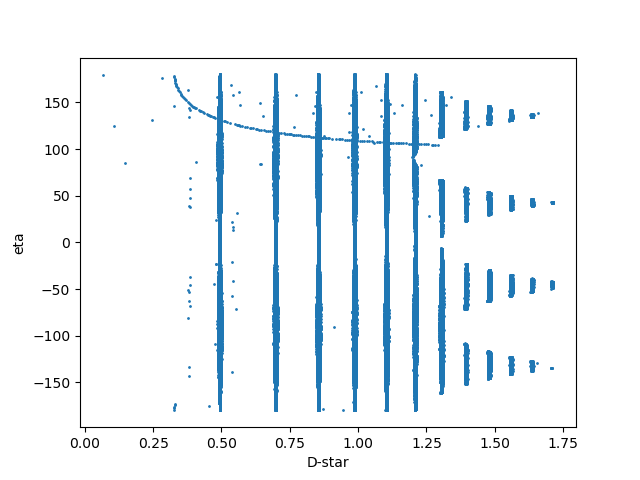

In [10]:
# plot the 3D peaks (fewer of them) as a cake (two-theta vs eta)
# if the parameters in the par file are good, these should look like straight lines

fig, ax = plt.subplots()

ax.scatter(cf_3d.ds, cf_3d.eta, s=1)

ax.set_xlabel("D-star")
ax.set_ylabel("eta")

plt.show()

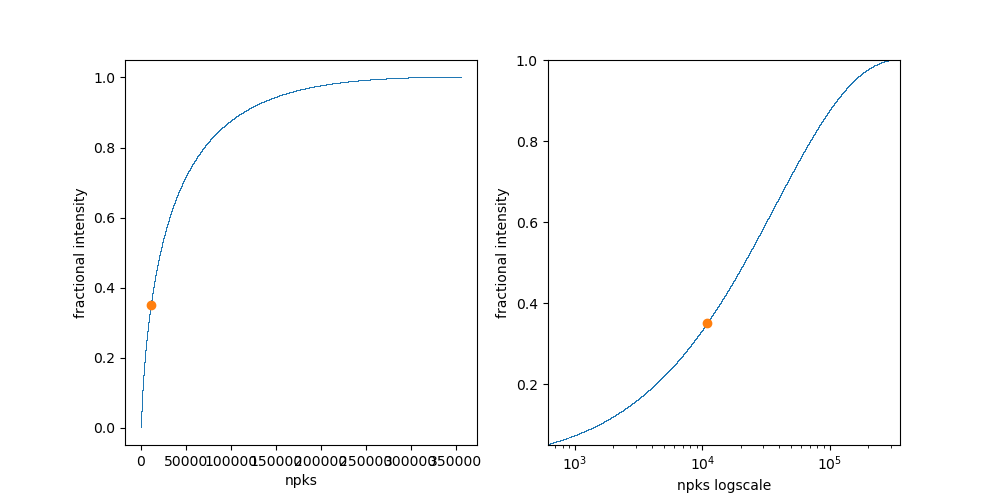

Got 10970 strong peaks for indexing


In [11]:
# here we are filtering our peaks (cf_2d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer
# because we have so many 3d peaks, we will filter down to 3 rings

# USER: modify the "frac" parameter below and re-run the cell until we have around 10,000 peaks for indexing
# we may choose more for the full index in the next notebook, but for now we want to quickly index only our strong grains

cf_strong = utils.selectpeaks(cf_3d, frac=0.35, dsmax=0.92, doplot=0.05, dstol=0.01)
print(f"Got {cf_strong.nrows} strong peaks for indexing")
cf_strong.writefile(f'{sample}_{dataset}_3d_peaks_strong.flt')

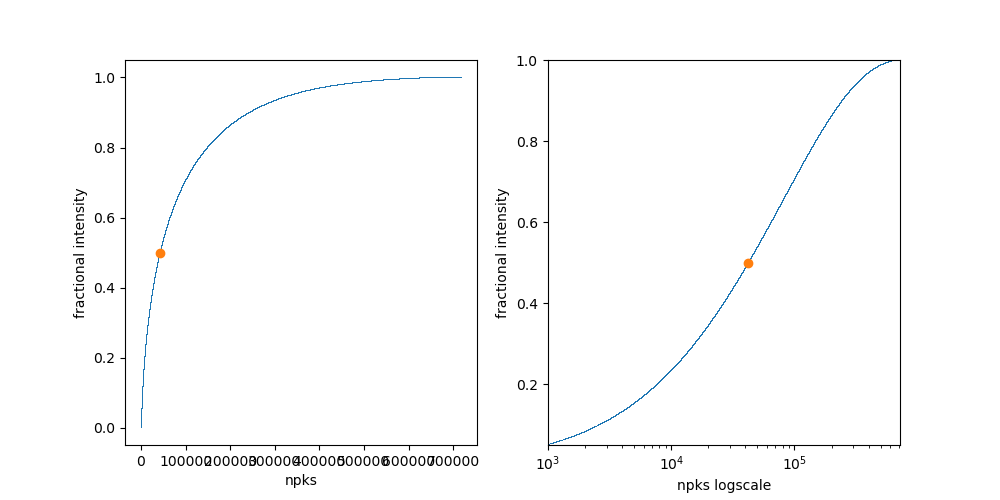

Got 42243 strong peaks for makemap


In [76]:
# we will also export some additional strong peaks across all rings
# this will be useful for grain refinement later (using makemap)

cf_strong_allrings = utils.selectpeaks(cf_3d, frac=0.50, dsmax=cf_3d.ds.max(), doplot=0.05, dstol=0.01)
print(f"Got {cf_strong_allrings.nrows} strong peaks for makemap")
cf_strong_allrings_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt'
cf_strong_allrings.writefile(cf_strong_allrings_path)

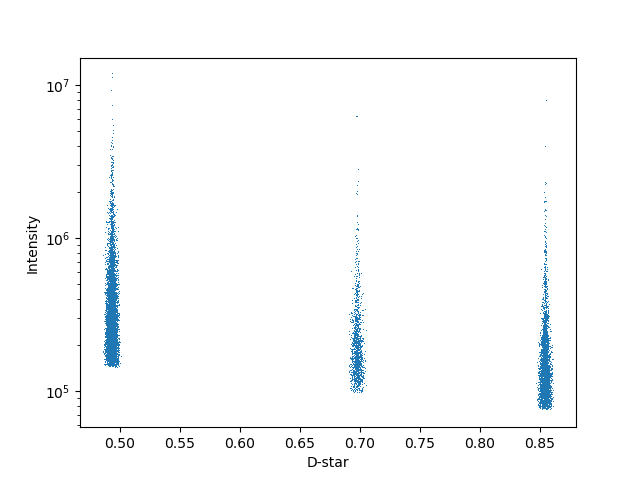

In [11]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots()

ax.plot(cf_strong.ds, cf_strong.sum_intensity,',')
ax.semilogy()

ax.set_xlabel("D-star")
ax.set_ylabel("Intensity")

plt.show()

In [12]:
# now we can define a unit cell from our parameters

Fe = ImageD11.unitcell.unitcell_from_parameters(cf_strong.parameters)
Fe.makerings(cf_strong.ds.max())

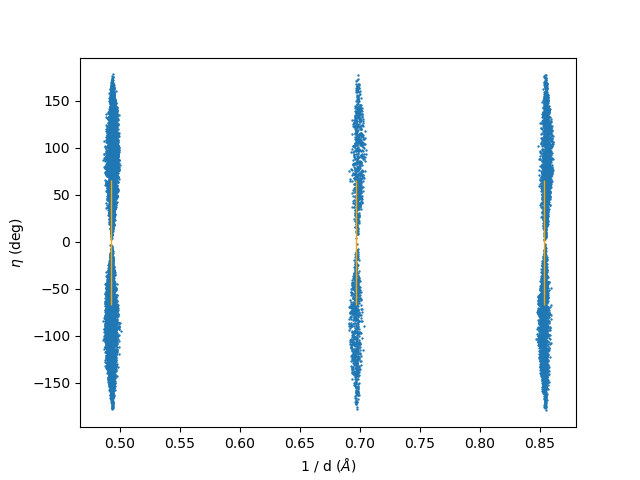

In [13]:
# now let's plot our peaks again, with the rings from the unitcell included, to check our lattice parameters are good

fig, ax = plt.subplots()

skip=1
ax.scatter( cf_strong.ds[::skip], cf_strong.eta[::skip], s=0.5)
ax.plot( Fe.ringds, [0,]*len(Fe.ringds), '|', ms=90, c='orange')
ax.set_xlabel('1 / d ($\AA$)')
ax.set_ylabel('$\\eta$ (deg)')

plt.show()

In [14]:
# specify our ImageD11 indexer with these peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer.ds_tol = 0.05

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

info: gv: [[-0.0514113   0.29166867 -0.80263494]
 [-0.01825324  0.02886582 -0.49310015]
 [-0.03197414 -0.0498011  -0.48988343]
 ...
 [ 0.19524438  0.45544693  0.0010038 ]
 [ 0.00366492  0.85364564  0.03477097]
 [-0.05285567 -0.38898744  0.29488916]] (10970, 3) float64
Indexing 10970 peaks
info: Assign to rings, maximum d-spacing considered: 0.861486
info: Ring assignment array shape (10970,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 2   ( -2, -1, -1)   24   3102       0     3102   N/A     N/A  9.29
info: Ring 1   ( -2,  0,  0)    6   1355       0     1355   N/A     N/A  7.58
info: Ring 0   ( -1, -1,  0)   12   6513       0     6513   N/A     N/A  5.36
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (10970, 3)


In [15]:
# we want to index low multiplicity rings
# choose max_multiplicity such that we get 2-3 low-multiplicity rings
# in this case, we will find orientations on 2 rings (faster for many peaks) and include the third ring for minpeaks calculations

max_multiplicity = 13

min_counts_on_ring = 0

n_peaks_expected = 0
rings = []
for i, dstar in enumerate(indexer.unitcell.ringds):
    multiplicity = len(indexer.unitcell.ringhkls[indexer.unitcell.ringds[i]])
    counts_on_this_ring = (indexer.ra == i).sum()
    if counts_on_this_ring > min_counts_on_ring:
        n_peaks_expected += multiplicity
        if multiplicity < max_multiplicity:
            rings.append((counts_on_this_ring, multiplicity, i))
        
rings.sort()

print(f"{n_peaks_expected} peaks expected")
print(f"Trying these rings (counts, multiplicity, ring number): {rings}")

# USER: specify the HKL tolerances you want to use for indexing
# hkl_tols_seq = [0.02, 0.03, 0.04, 0.05, 0.1]   # BEST
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04]

# USER: specify the fraction of the total expected peaks
# fracs = [0.9, 0.75]  # BEST
fracs = [0.9, 0.75]

# ImageD11.cImageD11.cimaged11_omp_set_num_threads(1)
ImageD11.indexing.loglevel=3

# indexer.uniqueness = 0.3
indexer.cosine_tol = np.cos(np.radians(90.25))

# iterate over HKL tolerances
for frac in fracs:
    for tol in hkl_tols_seq:
        indexer.minpks = n_peaks_expected*frac
        indexer.hkl_tol = tol
        
        # iterate over rings
        
        for i in range(len(rings)):
            for j in range(i, len(rings)):
                indexer.ring_1 = rings[i][2]
                indexer.ring_2 = rings[j][2]
    
                indexer.find()
                indexer.scorethem()                

        print(frac, tol, len(indexer.ubis))

42 peaks expected
Trying these rings (counts, multiplicity, ring number): [(1355, 6, 1), (6513, 12, 0)]
0.9 0.01 0
0.9 0.02 86
0.9 0.03 194
0.9 0.04 256
0.75 0.01 256
0.75 0.02 256
0.75 0.03 257
0.75 0.04 279


In [55]:
# create grain objects
grains = [ImageD11.grain.grain(ubi, translation=np.array([0., 0., 0.])) for ubi in indexer.ubis]

# set grain GIDs (useful if we ever delete a grain)
for i, g in enumerate(grains):
    g.gid = i

In [56]:
tmp_ubi_path = f'{sample}_{dataset}_grains.ubi'
tmp_map_path = f'{sample}_{dataset}_grains.map'

new_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.new'  # flt file containing assignments from makemap
unindexed_flt_path = f'{sample}_{dataset}_3d_peaks_strong_all_rings.flt.unindexed'  # remaining unassigned peaks from makemap

In [57]:
ImageD11.grain.write_grain_file(tmp_ubi_path, grains)

In [58]:
omegas_sorted = np.sort(ds.omega)[0]
omega_slop = np.round(np.diff(omegas_sorted).mean(), 3)

makemap_hkl_tol_seq = [0.05, 0.025, 0.01]

In [77]:
for inc, makemap_tol in enumerate(makemap_hkl_tol_seq):
    print(f"Running makemap {inc+1}/{len(makemap_hkl_tol_seq)}")
    if inc == 0:  # ubi into map
        makemap_output = !makemap.py -p {parfile} -u {tmp_ubi_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort
    else:  # map into map
        makemap_output = !makemap.py -p {parfile} -u {tmp_map_path} -U {tmp_map_path} -f {cf_strong_allrings_path} -F {unindexed_flt_path} -s cubic -t {makemap_hkl_tol_seq[inc]} --omega_slop={omega_slop} --no_sort

Running makemap 1/3
Running makemap 2/3
Running makemap 3/3


In [78]:
grains_refined_positions = ImageD11.grain.read_grain_file(tmp_map_path)

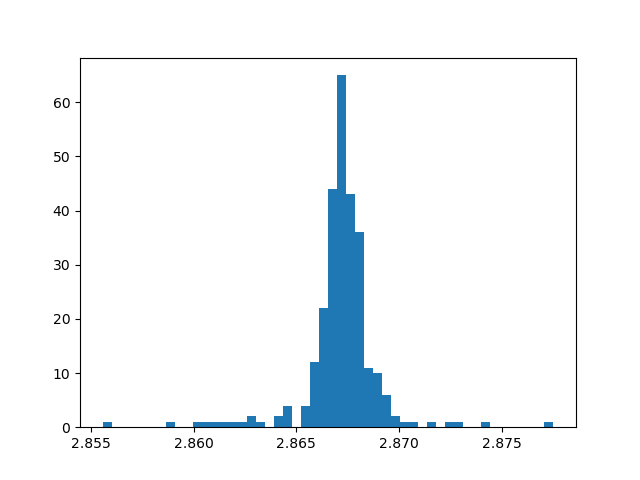

In [79]:
fig, ax = plt.subplots()
ax.hist([np.mean(g.unitcell[0:3]) for g in grains_refined_positions], bins=50)
plt.show()

In [80]:
refine_output = !refine_em.py {new_flt_path} {tmp_map_path} {parfile} --omega_slop={omega_slop}

In [84]:
# work out how many parameter files are missing
# check the missing .par files, and copy to cover the missing files
import shutil
print(f'Total number of files expected = {len(grains_refined_positions)}')

for i in range(len(grains_refined_positions)):
    filename =  f"{i}.par"
    if not (os.path.isfile(filename)):
        print(f'Missing {filename}')
        print(f'Copying {i-1}.par to {filename}')
        shutil.copy(str(i-1) + '.par', filename)

Total number of files expected =  279
Missing 4.par
Copying 3.par to 4.par
Missing 81.par
Copying 80.par to 81.par
Missing 107.par
Copying 106.par to 107.par
Missing 127.par
Copying 126.par to 127.par


In [85]:
refined_parfile = 'Fe_refined.par'

In [86]:
avg_par_output = !avg_par.py {refined_parfile} {len(grains_refined_positions)}

In [87]:
# clean up temporary files
for i in range(len(grains_refined_positions)):
    pfile = str(i) + '.par'
    ffile = str(i) + '.flt'
    ufile = str(i) + '.ubi'
    for filename in [pfile, ffile, ufile]:
        if os.path.isfile(filename):
            os.remove(filename)

In [ ]:
# refined parameter file has now been created!

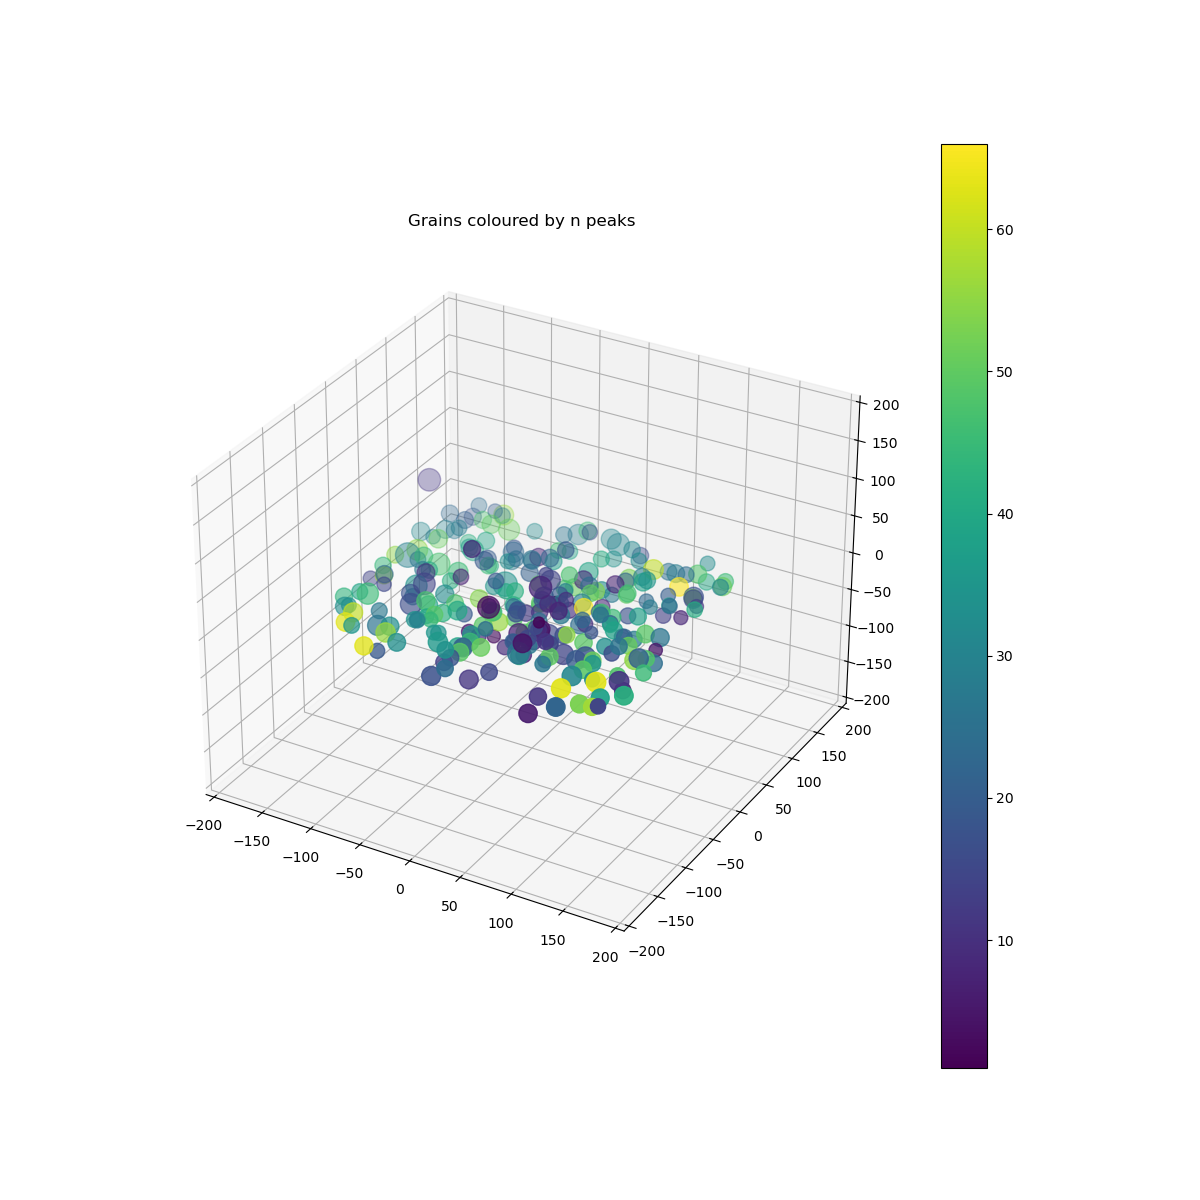

In [23]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.translation[0] for grain in grains2]
yy = [grain.translation[1] for grain in grains2]
zz = [grain.translation[2] for grain in grains2]
# col = [utils.grain_to_rgb(grain) for grain in grains2]
col = [float(grain.npks) for grain in grains2]
sizes = [0.01*(float(grain.intensity_info.split("mean = ")[1].split(" , ")[0].replace("'", ""))) for grain in grains2]
scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz, c=col, s=sizes)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by n peaks")
plt.show()

In [ ]:
# refine_em